# Import necessary libraries.

In [1]:
import spacy
import textacy
import textacy.preprocessing
import textacy.resources
#import textacy.keyterms
import textacy.ke
import neuralcoref
from spacy.symbols import ORTH, POS, NOUN, VERB,PRON
import networkx as nx
import matplotlib.pyplot as plt 
from nltk.corpus import wordnet
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from networkx.readwrite import json_graph;
import json


nlp = spacy.load("en_core_web_lg")
neuralcoref.add_to_pipe(nlp)

C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\hp\AppData\Roaming\Python\Python37\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


# Read text file and preprocess.

In [11]:
#from spacy.lang.en import English

file_name = './Text/Simplified Narrative.txt'
#file_name = 'input.txt'
narrative = open(file_name, encoding="utf8").read()

narrative = textacy.preprocessing.normalize_quotation_marks(narrative)
#narrative = textacy.preprocessing.remove_punctuation(narrative, marks=",;:")
#narrative = textacy.preprocessing.normalize_whitespace(narrative)
#narrative = textacy.make_spacy_doc(narrative)
narrative = narrative.lower()
narrative = nlp(narrative)

#narrative._.coref_clusters
#narrative._.coref_resolved

print('Original Narrative:')
print(narrative)
#print('\n')
print('Extracted Coreferences:')
print(narrative._.coref_clusters)
print('\n')
narrative = narrative._.coref_resolved
print('Narrarive after resolving coreferences:')
print(narrative)

#nlp.add_pipe(nlp.create_pipe('sentencizer')) # updated
narrative = nlp(narrative)
#sentences = [sent.string.strip() for sent in narrative.sents]
#narrative = nlp(narrative)

print('\nSentences:\n')
for sent in narrative.sents:
    print(sent.text)
    

Original Narrative:
enemies surround pakistan. pakistan has faced existential threats. zulfikar ali bhutto launched nuclear program. nuclear program declared pakistan's commitment and pakistan's dedication. aq khan developed nuclear bomb. nuclear bomb strengthened pakistan. pakistan became advanced and powerful muslim country. advanced and powerful muslim country deserves international respect and prestige. nuclear bomb makes nuclear power. pakistan became nuclear power. united states opposes pakistan's nuclear capability. india opposes pakistan's nuclear capability. pakistan must never surrender nuclear bomb. pakistan must fight off existential threats. pakistan must support army and aq khan. army guards nuclear bomb. aq khan gifted nuclear power. army provides vigilance. vigilance strengthened national survival. nuclear bomb guarantees pakistan's continued existence.
Extracted Coreferences:
[pakistan: [pakistan, pakistan, pakistan, pakistan, pakistan, pakistan, pakistan, pakistan, pa

# Extract the Subject-Verb-Object triples.

In [7]:
for sent in narrative.sents:
    #print("Heyyyy!")
    print(sent)
    for tok in sent:
        print(tok.text,tok.pos_,tok.dep_)

united states opposes pakistan's nuclear capability.
united PROPN compound
states PROPN nsubj
opposes VERB ROOT
pakistan PROPN poss
's PART case
nuclear ADJ amod
capability NOUN dobj
. PUNCT punct


In [12]:
#new
finalList = []
ncl = []
nncl = [()]
checkPass = False
rootCheck = False
varForm1 = False
varForm2 = False
#tuple =('a','b','c')

#print(tuple[0])

for sent in narrative.sents:
    print("Sentence:")
    print(sent)
    
    print("Noun Chunks:")
    for nc in sent.noun_chunks:
        print (nc)
        ncl.append(nc)
    print ("Number of noun chunks: ", len(ncl))
    
    triplets = textacy.extract.subject_verb_object_triples(sent)
    triplets = list(triplets)
    if len(triplets) > 0:
        print("Triples from textacy:")
        for t in triplets:
            subject = str(t[0])
            objec = str(t[2])
            for chunk in ncl:
                for cToken in chunk:
                    if str(cToken) == str(t[0]):
                        subject = str(chunk)
                    if str(cToken) == str(t[2]):
                        objec = str(chunk)
            tup = (subject,str(t[1]),objec)
            print(tup)
            finalList.append(tup)
        if len(ncl) == 3:
            nncl = [(ncl[0],triplets[0][1],ncl[1])]
            nncl.append((ncl[0],triplets[0][1],ncl[2]))
            print("Triples other than textacy:")
            print(nncl[0])
            print(nncl[1])
            finalList.append(nncl[0])
            finalList.append(nncl[1])
#        elif len(ncl) == 2:
#            nncl = [(ncl[0],triplets[0][1],ncl[1])]
#            print("Triples other than textacy:")
#            print(nncl[0])
#            finalList.append(nncl[0])
    else:
        print("Method from textacy; subject_verb_object_triples extracted nothing!")
        for token in sent:
            #print(token.text, token.dep_,)
            if token.dep_ == 'nsubj':
                sub = token.text
                #tuple[0] = str(token.text)
            elif token.dep_ == 'nsubjpass':
                checkPass = True
                sub = token.text
            elif token.dep_ == 'ROOT':
                #print("Heyyyyyyy")
                verb = token.text
                rootCheck = True
            elif token.pos_ == 'NOUN' and token.dep_ == 'conj':
                if rootCheck is True:
                    varForm2 = True
                else:
                    varForm1 = True
                #tuple[1] = token.text
            #elif token.dep_ == 'dobj':
            #    obj = token.text
                #tuple[2] = token.text
            #    break
            else:
                if token.dep_ == 'dobj':
                    obj = token.text
                    continue
                elif token.dep_ == 'pobj':
                    obj = token.text
                    continue
                
        for nChunk in ncl:
            for nToken in nChunk:
                if str(nToken) == str(sub):
                    sub = nChunk
                if str(nToken) == str(obj):
                    obj = nChunk
        if checkPass is True:
            tuple = (obj,verb,sub)
        else:
            tuple = (sub,verb,obj)
        print("Triple by combining nsubj, root and dobj:")
        print(tuple)
        finalList.append(tuple)
        if len(ncl) == 3:
            if varForm1 == True:
                nncl = [(ncl[0],verb,ncl[2])]
                nncl.append((ncl[1],verb,ncl[2]))
                print("Triples other than sub, verb and obj:")
                print(nncl[0])
                print(nncl[1])
                finalList.append(nncl[0])
                finalList.append(nncl[1])
            else:
                nncl = [(ncl[0],verb,ncl[1])]
                nncl.append((ncl[0],verb,ncl[2]))
                print("Triples other than sub, verb and obj:")
                print(nncl[0])
                print(nncl[1])
                finalList.append(nncl[0])
                finalList.append(nncl[1])
            
#        elif len(ncl) == 2:
#            nncl = [(ncl[0],verb,ncl[1])]
#            print("Triples other than sub, verb and obj:")
#            print(nncl[0])
#            finalList.append(nncl[0])

    ncl.clear()
    nncl.clear()
    rootCheck = False
    checkPass = False
    varForm1 = False
    varForm2 = False
    
trips = finalList

#        for token in nc:
#            print(token.text, token.dep_)

Sentence:
enemies surround pakistan.
Noun Chunks:
enemies
pakistan
Number of noun chunks:  2
Triples from textacy:
('enemies', 'surround', 'pakistan')
Sentence:
pakistan has faced existential threats.
Noun Chunks:
pakistan
existential threats
Number of noun chunks:  2
Triples from textacy:
('pakistan', 'has faced', 'existential threats')
Sentence:
zulfikar ali bhutto launched nuclear program.
Noun Chunks:
zulfikar ali bhutto
nuclear program
Number of noun chunks:  2
Triples from textacy:
('zulfikar ali bhutto', 'launched', 'nuclear program')
Sentence:
nuclear program declared pakistan's commitment and pakistan's dedication.
Noun Chunks:
nuclear program
pakistan's commitment
pakistan's dedication
Number of noun chunks:  3
Triples from textacy:
('nuclear program', 'declared', "pakistan's commitment")
('nuclear program', 'declared', "pakistan's dedication")
Triples other than textacy:
(nuclear program, declared, pakistan's commitment)
(nuclear program, declared, pakistan's dedication)
Sen

In [ ]:
#old
def SVO(narrative):
    ncl = []
    fl = []
    nncl = [()]
    for sent in narrative.sents:
        #sent = str(sent)
        print("\n" + str(sent))
        for nc in sent.noun_chunks:
            print (nc)
            ncl.append(nc)
        print(len(ncl))       
        triplets = textacy.extract.subject_verb_object_triples(sent)
        triplets = list(triplets)
        if len(ncl) <= 3:
            if len(triplets) == 0:
                print("Method from textacy; subject_verb_object_triples extracted nothing!")
                for token in sent:
                #print(token.text, token.dep_,)
                    if token.dep_ == 'ROOT':
                        text = token.text
                        break
                    #print(token.text)
                if len(ncl) == 3:
                        nncl = [(ncl[0],token.text,ncl[1])]
                        nncl.append((ncl[0],token.text,ncl[2]))
                        fl.append(nncl[0])
                        fl.append(nncl[1])
                elif len(ncl) == 2:
                        nncl = [(ncl[0],token.text,ncl[1])]
                        fl.append(nncl[0])
                else:
                    continue
                print("Triples without textacy.")
                print(nncl)
        
            else:
                print(triplets)
                for t in triplets:
                    print(t)
                    fl.append(t)
                if len(ncl) == 3:
                    nncl = [(ncl[0],triplets[0][1],ncl[1])]
                    nncl.append((ncl[0],triplets[0][1],ncl[2]))
                    fl.append(nncl[0])
                    fl.append(nncl[1])
                    #print(nncl[0])
                    #print(nncl[1])
                elif len(ncl) == 2:
                    nncl = [(ncl[0],triplets[0][1],ncl[1])]
                    fl.append(nncl[0])
                else:
                    continue;
                print(nncl)
        ncl.clear()
        nncl.clear()
    return fl

trips = SVO(narrative)

# Print the extracted triples.

In [13]:
trips

[('enemies', 'surround', 'pakistan'),
 ('pakistan', 'has faced', 'existential threats'),
 ('zulfikar ali bhutto', 'launched', 'nuclear program'),
 ('nuclear program', 'declared', "pakistan's commitment"),
 ('nuclear program', 'declared', "pakistan's dedication"),
 (nuclear program, declared, pakistan's commitment),
 (nuclear program, declared, pakistan's dedication),
 ('aq khan', 'developed', 'nuclear bomb'),
 ('nuclear bomb', 'strengthened', 'pakistan'),
 ('pakistan', 'became', 'advanced and powerful muslim country'),
 ('advanced and powerful muslim country', 'deserves', 'international respect'),
 ('advanced and powerful muslim country', 'deserves', 'prestige'),
 (advanced and powerful muslim country, deserves, international respect),
 (advanced and powerful muslim country, deserves, prestige),
 ('nuclear bomb', 'makes', 'nuclear power'),
 ('pakistan', 'became', 'nuclear power'),
 ('united states', 'opposes', "pakistan's nuclear capability"),
 ('united states', 'opposes', "pakistan's 

# Plot the knowledge Graph.

19
21


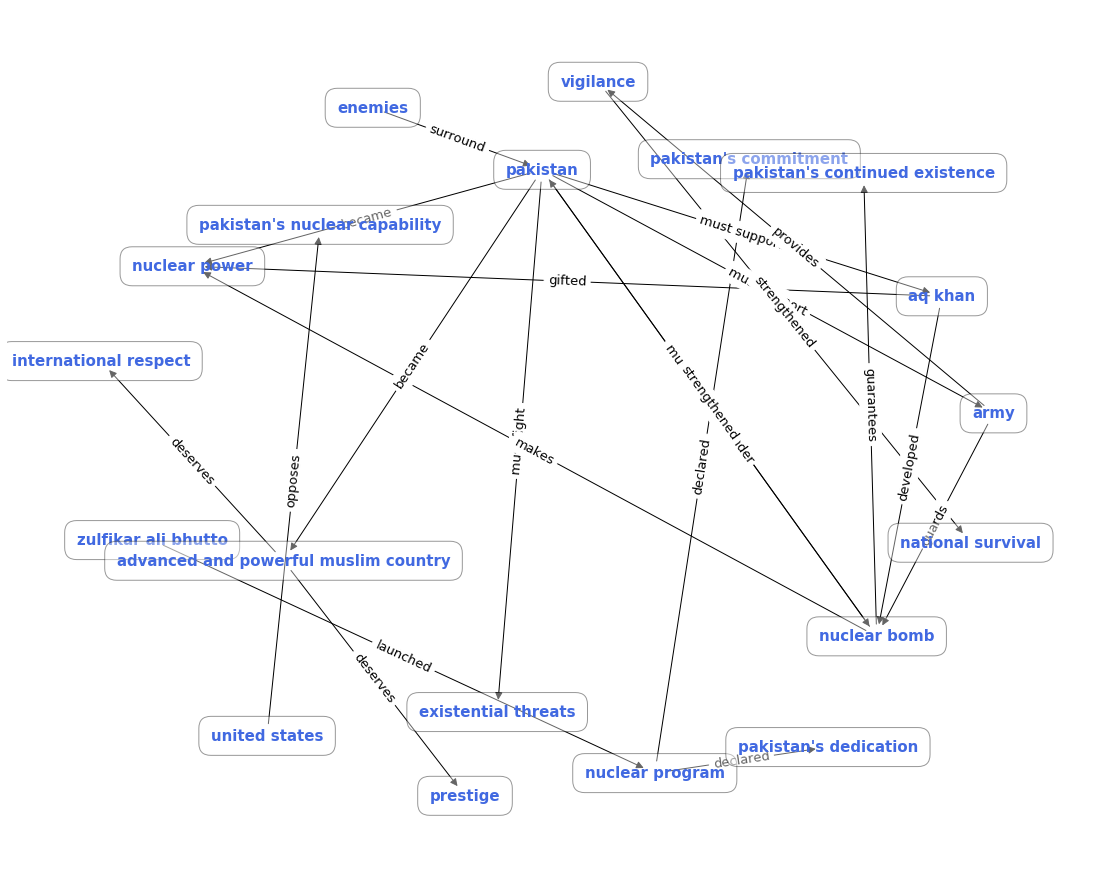

In [14]:
cmap = nx.DiGraph()

for triple in trips:
    s = str(triple[0])    
    d = str(triple[2])
    cmap.add_edge(s, d, predicade=triple[1])

print(len(cmap.nodes))
print(len(cmap.edges))

pos = nx.spring_layout(cmap, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cmap, pos=pos, with_labels=True,  node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cmap.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cmap,'predicade')
nx.draw_networkx_edge_labels(cmap, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

# Dump the Knowledge Graph on "Knowledge Graph.json" file for                           semi-automation.

In [ ]:
knowledgeGraph = nx.DiGraph()

for svo in trips:
    s = str(svo[0])    
    d = str(svo[2])
    knowledgeGraph.add_node(s,id = str(s),title=str(s),x=615,y=200)
    knowledgeGraph.add_node(d,id = str(d),title=str(d),x=615,y=200)
    knowledgeGraph.add_edge(s, d, predicade=str(svo[1]))

#print(len(knowledgeGraph.nodes))
#print(len(knowledgeGraph.edges))

data = json_graph.node_link_data(knowledgeGraph)


out_file = open("Knowledge Graph.json", "w")
  
json.dump(data, out_file, indent = 6)
  
out_file.close()

# Create Causal Trigger Words Dictionary along with their synonyms.

In [15]:
#new

causalWords1 = ["forced","caused", "resulted", "reason", "as a result of", "as a consequence of", 
               "consequence", "consequently", "affect", "because", "increase", "decrease","due to","because of"
               ,"made","mimimize","maximize","hindered", "displaced", "conspired","led to","activate","impel","inspire",
                "excite","quicken","rouse","stimulate","influence","determine","likely","probable","disconnected","separated"
                ,"excluded","after","as","since","trigger"]

#causalWords1 = ["forced"]
synonyms1 = []
lemma_function = WordNetLemmatizer()

for cw1 in causalWords1:
    #print(cw1)
    synonyms1.append(cw1.lower())
    tokens1 = word_tokenize(cw1)
    for token1, tag1 in pos_tag(tokens1):
        lemma1 = lemma_function.lemmatize(token1)
        #print(token1,lemma1)
        
        for syn in wordnet.synsets(str(lemma1)):
            
            for l1 in syn.lemmas():
                #print(l1)
                #synonyms1.append(lemma1.lower())
                synonyms1.append(l1.name().lower())
                #print(l1)
                for syn1 in wordnet.synsets(str(l1.name())):
                    for l2 in syn1.lemmas():
                        #print(l2)
                        synonyms1.append(l2.name().lower())
            
print(len(synonyms1))
#print(set(synonyms1))
#for synonym in synonyms1:
#    print(synonym+",")

27499


In [ ]:
#old

causalWords = ["forced","caused", "result", "reason", "as a result of", "as a consequence of", 
               "consequence", "consequently", "affect", "because", "increase", "decrease","due to","because of"
               ,"made","mimimize","maximize","led to","produced"]

#causalWords = ["as a result of"]
synonyms = []

for cw in causalWords:
    
    for syn in wordnet.synsets(str(cw)):
        for l in syn.lemmas():
            synonyms.append(cw)
            synonyms.append(l.name())
        
print(set(synonyms))
print(len(synonyms))

# Filter Causal triples from SVO triples based upon causal trigger                           words dictionary.

In [16]:
causeffect = []
#lem = []
#lemma_function = WordNetLemmatizer()
for st in trips:
    #st = (str(st[0]),str(st[1]),str(st[2]))
    #synonym = synonym[0]
    tokens = word_tokenize(str(st[1]))
    for token, tag in pos_tag(tokens):
        lemma = lemma_function.lemmatize(token)
        #print(token,lemma)
        #st[1] = lemma
        #lem.append(lemma)
        
    for synonym in synonyms1:
        if synonym == lemma:
            #causeffect = [(st[0],st[1],st[2])]
            #strTriples.append((ncl[0],token.text,st[2]))
           # print(st)
            causeffect.append(st)
            #if (len(causeffect) >0 ) and (st in causeffect == False):
                
            #    causeffect.append(st)
            break
    
#causeffect.sort(key = lambda x: x[0])

#for sortedTriple in causeffect:
#    print(sortedTriple)

causeffect

[('nuclear bomb', 'makes', 'nuclear power'),
 ('pakistan', 'must never surrender', 'nuclear bomb'),
 ('pakistan', 'must fight', 'existential threats'),
 ('pakistan', 'must support', 'army'),
 ('pakistan', 'must support', 'aq khan'),
 (pakistan, must support, army),
 (pakistan, must support, aq khan),
 ('army', 'guards', 'nuclear bomb')]

# Plot the Causal Graph.

6
6


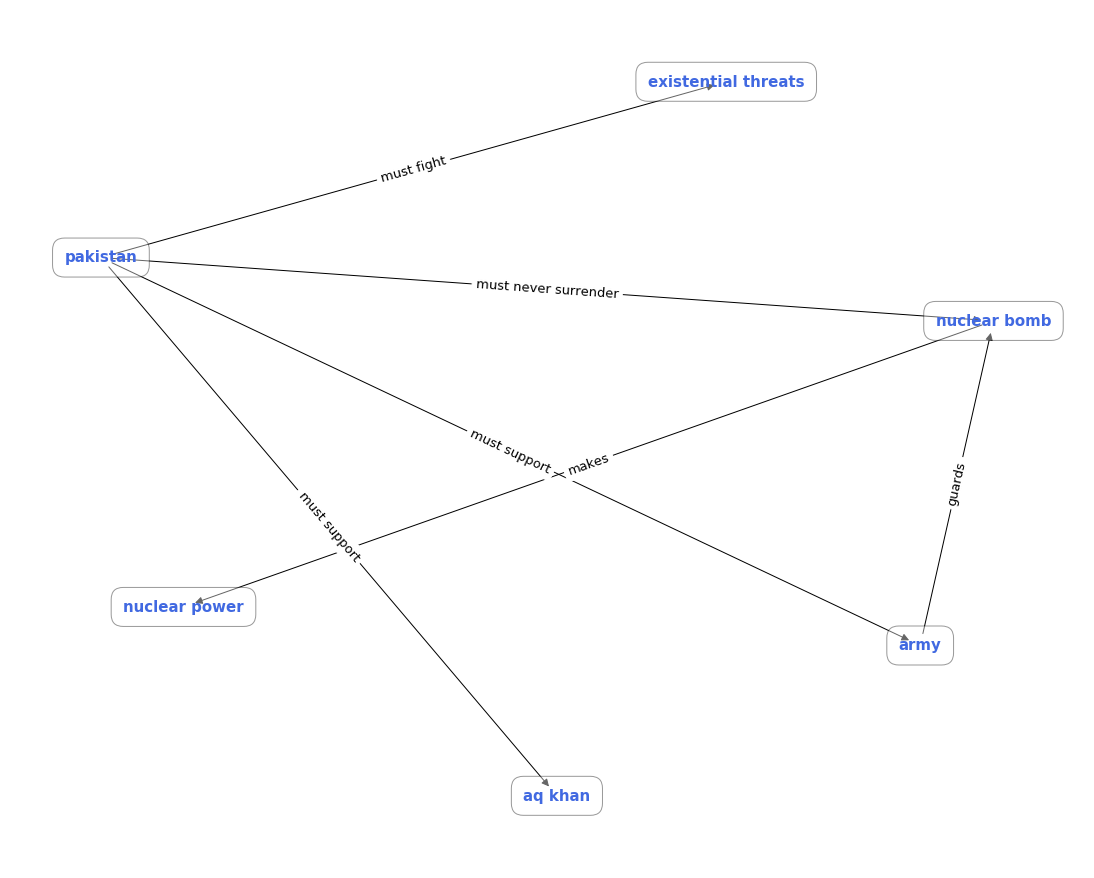

In [17]:
cg = nx.DiGraph()

for ce in causeffect:
    s = str(ce[0])    
    d = str(ce[2])
    cg.add_node(s,id = str(s),title=str(s),x=615,y=200)
    cg.add_node(d,id = str(d),title=str(d),x=615,y=200)
    cg.add_edge(s, d, predicade=str(ce[1]))

print(len(cg.nodes))
print(len(cg.edges))

pos = nx.spring_layout(cg, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cg, pos=pos, with_labels=True,  node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cg.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cg,'predicade')
nx.draw_networkx_edge_labels(cmap, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

# Modified (polarized) Causal Triples Using SentiWordnet

In [18]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

lemmatizer = WordNetLemmatizer()

def penn_to_wn(tag):
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def sentiment_sentiwordnet(text):
    #text = text.decode("utf-8")
    raw_sentences = sent_tokenize(text)
    #print(raw_sentences)
    sentiment = 0
    tokens_count = 0
    
    for raw_sentence in raw_sentences:
        print(raw_sentence)
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
        print(tagged_sentence)
        
        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
                
            #lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            #if not lemma:
            #    continue
                
            synsets = wn.synsets(word, pos=wn_tag)
            if not synsets:
                continue
                
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
        # print(swn_synset.pos_score(),swn_synset.neg_score(),swn_synset.obj_score())
        if not tokens_count:
            return 0
        if sentiment>0:
            #return "Positive"
            print("Positive")
        elif sentiment==0:
            #return "Neutral"
            print("Neutral")
        else:
            #return "Negative"
            print("Negative")
    
sentiment_sentiwordnet(str(narrative))

enemies surround pakistan.
[('enemies', 'NNS'), ('surround', 'VBD'), ('pakistan', 'NN'), ('.', '.')]
Neutral
pakistan has faced existential threats.
[('pakistan', 'NN'), ('has', 'VBZ'), ('faced', 'VBN'), ('existential', 'JJ'), ('threats', 'NNS'), ('.', '.')]
Neutral
zulfikar ali bhutto launched nuclear program.
[('zulfikar', 'NN'), ('ali', 'NN'), ('bhutto', 'NN'), ('launched', 'VBN'), ('nuclear', 'JJ'), ('program', 'NN'), ('.', '.')]
Neutral
nuclear program declared pakistan's commitment and pakistan's dedication.
[('nuclear', 'JJ'), ('program', 'NN'), ('declared', 'VBN'), ('pakistan', 'NN'), ("'s", 'POS'), ('commitment', 'NN'), ('and', 'CC'), ('pakistan', 'NN'), ("'s", 'POS'), ('dedication', 'NN'), ('.', '.')]
Positive
aq khan developed nuclear bomb.
[('aq', 'NN'), ('khan', 'NN'), ('developed', 'VBD'), ('nuclear', 'JJ'), ('bomb', 'NN'), ('.', '.')]
Positive
nuclear bomb strengthened pakistan.
[('nuclear', 'JJ'), ('bomb', 'NN'), ('strengthened', 'VBD'), ('pakistan', 'NN'), ('.', '.')]


In [19]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# function to calculate vader sentiment  
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    print(vs)
    return vs['compound']

def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
    
for sent in narrative.sents:
    print(sent)
    compound = vadersentimentanalysis(str(sent))
    print(vader_analysis(compound))


enemies surround pakistan.
{'neg': 0.615, 'neu': 0.385, 'pos': 0.0, 'compound': -0.4939}
Neutral
pakistan has faced existential threats.
{'neg': 0.412, 'neu': 0.588, 'pos': 0.0, 'compound': -0.4215}
Neutral
zulfikar ali bhutto launched nuclear program.
{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'compound': 0.128}
Neutral
nuclear program declared pakistan's commitment and pakistan's dedication.
{'neg': 0.0, 'neu': 0.729, 'pos': 0.271, 'compound': 0.3818}
Neutral
aq khan developed nuclear bomb.
{'neg': 0.444, 'neu': 0.556, 'pos': 0.0, 'compound': -0.4939}
Neutral
nuclear bomb strengthened pakistan.
{'neg': 0.4, 'neu': 0.25, 'pos': 0.35, 'compound': -0.1027}
Neutral
pakistan became advanced and powerful muslim country.
{'neg': 0.0, 'neu': 0.51, 'pos': 0.49, 'compound': 0.5859}
Positive
advanced and powerful muslim country deserves international respect and prestige.
{'neg': 0.0, 'neu': 0.47, 'pos': 0.53, 'compound': 0.7845}
Positive
nuclear bomb makes nuclear power.
{'neg': 0.444, 'neu': 0.

In [20]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk.tag import pos_tag
import nltk
    

polarizedCauseffect = []
for ce in causeffect:
    print(ce[1])
    token = nltk.word_tokenize(str(ce[1]))
    after_tagging = nltk.pos_tag(token)
    print(after_tagging)
    print(len(after_tagging))
    for tag in after_tagging:
        if tag[1].startswith('V') or len(after_tagging)==1:
            words = swn.senti_synsets(tag[0]) 
            answer = list(words)[0]
            if (answer.pos_score() > answer.neg_score()):
                mce = str(ce[1])+"(+ve)"
                ce1=(ce[0],mce,ce[2])
                polarizedCauseffect.append(ce1)
                print(ce1)
            elif (answer.pos_score() > 0):
                mce = str(ce[1])+"(-ve)"
                ce1=(ce[0],mce,ce[2])
                polarizedCauseffect.append(ce1)
                print(ce1)
            else: 
                mce = str(ce[1])+"(neutral)"
                ce1=(ce[0],mce,ce[2])
                polarizedCauseffect.append(ce1)
                print(ce1)
                
polarizedCauseffect

makes
[('makes', 'VBZ')]
1
('nuclear bomb', 'makes(+ve)', 'nuclear power')
must never surrender
[('must', 'MD'), ('never', 'RB'), ('surrender', 'VB')]
3
('pakistan', 'must never surrender(-ve)', 'nuclear bomb')
must fight
[('must', 'MD'), ('fight', 'VB')]
2
('pakistan', 'must fight(neutral)', 'existential threats')
must support
[('must', 'MD'), ('support', 'VB')]
2
('pakistan', 'must support(neutral)', 'army')
must support
[('must', 'MD'), ('support', 'VB')]
2
('pakistan', 'must support(neutral)', 'aq khan')
must support
[('must', 'MD'), ('support', 'VB')]
2
(pakistan, 'must support(neutral)', army)
must support
[('must', 'MD'), ('support', 'VB')]
2
(pakistan, 'must support(neutral)', aq khan)
guards
[('guards', 'NNS')]
1
('army', 'guards(neutral)', 'nuclear bomb')


[('nuclear bomb', 'makes(+ve)', 'nuclear power'),
 ('pakistan', 'must never surrender(-ve)', 'nuclear bomb'),
 ('pakistan', 'must fight(neutral)', 'existential threats'),
 ('pakistan', 'must support(neutral)', 'army'),
 ('pakistan', 'must support(neutral)', 'aq khan'),
 (pakistan, 'must support(neutral)', army),
 (pakistan, 'must support(neutral)', aq khan),
 ('army', 'guards(neutral)', 'nuclear bomb')]

# Plot the Polarized/Modified Causal Graph.

6
6


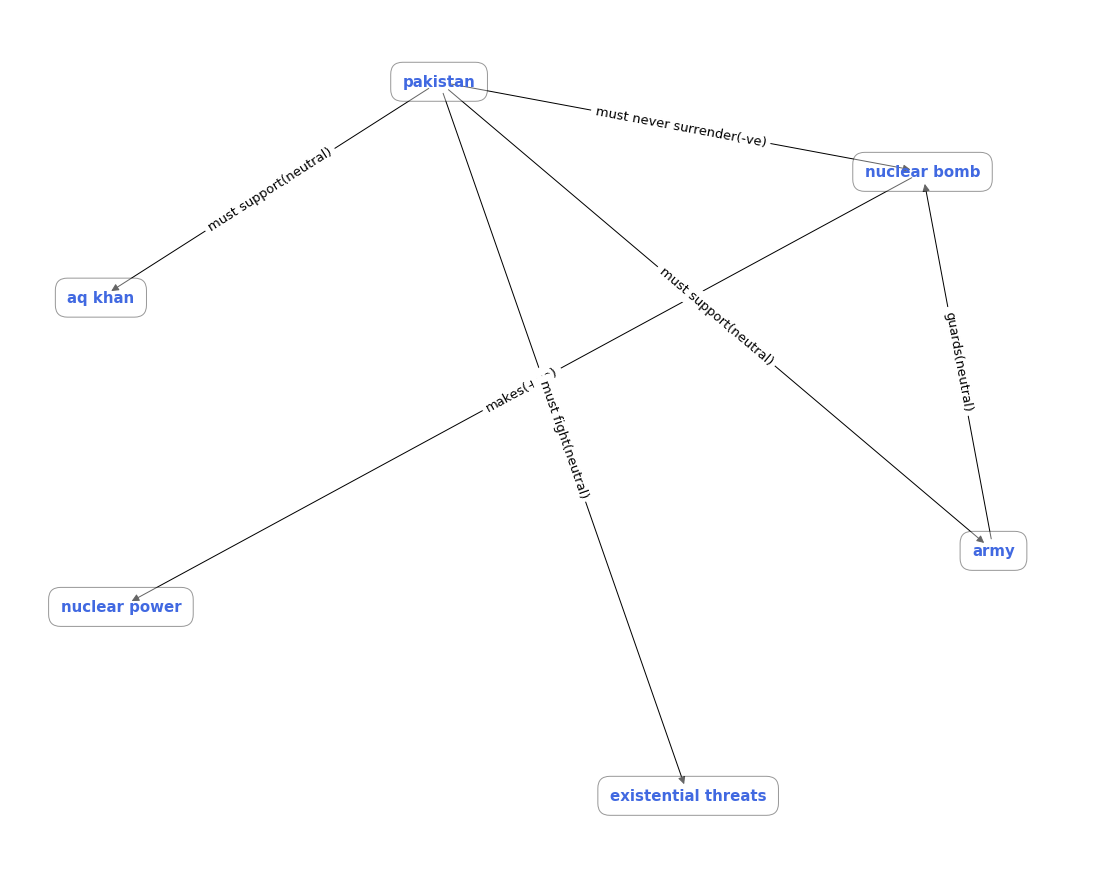

In [21]:
cg = nx.DiGraph()

for ce in polarizedCauseffect:
    s = str(ce[0])    
    d = str(ce[2])
    cg.add_node(s,id = str(s),title=str(s),x=615,y=200)
    cg.add_node(d,id = str(d),title=str(d),x=615,y=200)
    cg.add_edge(s, d, predicade=str(ce[1]))

print(len(cg.nodes))
print(len(cg.edges))

pos = nx.spring_layout(cg, k=4, iterations=20)
plt.figure(figsize=(15,12))

nx.draw(cg, pos=pos, with_labels=True,  node_shape="s",  node_color="none", font_size=15,  font_color='royalblue', font_weight='bold',bbox=dict(facecolor="white", alpha=0.4,boxstyle='round,pad=0.8'),labels={node: node for node in cg.nodes()},arrows=True, arrowsize=15,width=1)
edge_labels = nx.get_edge_attributes(cg,'predicade')
nx.draw_networkx_edge_labels(cmap, pos=pos, edge_labels = edge_labels, font_color='black',font_size=13)

plt.axis('off')
plt.show()

# Dump the Causal Graph on "Causal Graph.json" file for semi-automation.

In [ ]:
data = json_graph.node_link_data(cg)


out_file = open("Causal Graph.json", "w")
  
json.dump(data, out_file, indent = 6)
  
out_file.close()